In [1]:
%%capture
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename));

In [2]:
import numpy as np  
import pandas as pd   
import matplotlib.pyplot as plt
from PIL import Image


In [3]:
train_path = "/kaggle/input/datasets-lemlitbang-sibi-alphabets/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_V02/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_V02/training/"


img_types = ['.jpg', '.png', '.jpeg']

In [4]:
# Put output into a scrollable box
from IPython.display import display, HTML

# Define a function to create a scrollable frame.
def create_scrollable_output(output, height='300px'):
    display(HTML(
        '<div style="max-height: {0}; overflow-y: auto;"><pre>{1}</pre></div>'.format(height, output)
    ))

# Generate some long output
long_output = "\n".join(str(i) for i in range(1000))


In [5]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


def traverse_folders(path):
    output = ""
    for folder_name in sorted(os.listdir(path)):
        output += 'Folder name: ' + folder_name + "\n"
        
        img_data = []
        df = pd.DataFrame(columns=['path', 'width', 'height'])
        
        # * Don't forget .lower() !
        image_files = [file_name for file_name in sorted(os.listdir(os.path.join(path, folder_name))) 
                       if file_name.lower().endswith(tuple(img_types))]
        
        #print(image_files)
        
        for image_file in image_files:
            img_path=os.path.join(path, folder_name, image_file)
            with Image.open(img_path) as img:
                width, height = img.size
            img_data.append({'path': img_path, 'width': width, 'height': height})        

        df = pd.concat([df, pd.DataFrame(img_data)], ignore_index=True)
        

        #print(image_file,df['width'],df['height'])

        width_desc = df['width'].astype(int).describe()
        height_desc = df['height'].astype(int).describe()
        
        output += "Count: {}\n".format(int(width_desc['count']))
        output += "Width -  min: {}, max: {}\n".format(width_desc['min'], width_desc['max'])
        output += "Height -  min: {}, max: {}\n".format(height_desc['min'], height_desc['max'])
        output += '------------------\n'
    
    return output

scrollable_output = traverse_folders(train_path)
create_scrollable_output(scrollable_output)


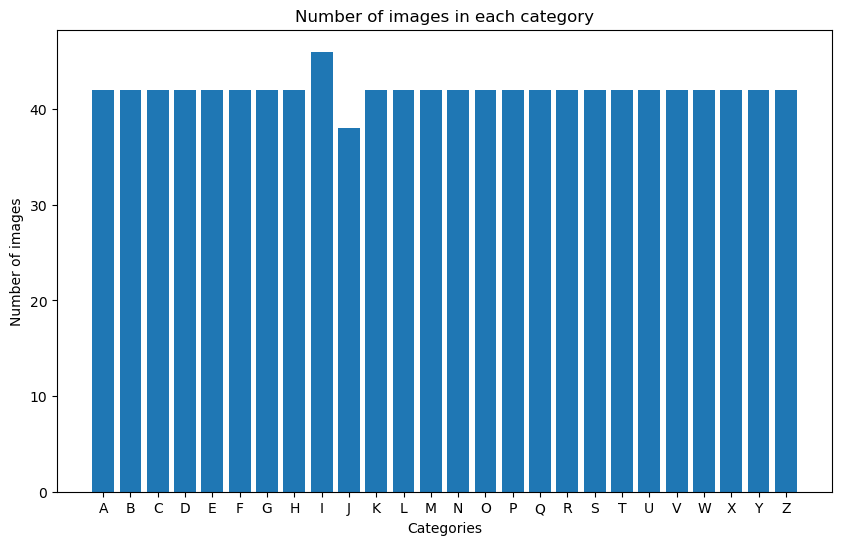

In [6]:
categories = sorted(os.listdir(train_path))

image_counts = [len([f for f in os.listdir(os.path.join(train_path, category)) 
                     if f.lower().endswith(tuple(img_types))]) for category in categories]

plt.figure(figsize=(10,6)) 
plt.bar(categories, image_counts)
plt.xlabel("Categories")
plt.ylabel("Number of images")
plt.title("Number of images in each category")
plt.show()


In [7]:
output_resized_train_path = "/kaggle/working/resized/resized_train"

def resize_images(image_dir, output_dir, size=(224, 224)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
    
    
    for category in sorted(os.listdir(image_dir)):
        category_dir = os.path.join(image_dir, category)
        output_category_dir = os.path.join(output_dir, category)
        
        if not os.path.exists(output_category_dir):
            os.mkdir(output_category_dir)
            
        print('Begin to resize folder: ',category_dir)
        for image_name in os.listdir(category_dir):
            if image_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                image_path = os.path.join(category_dir, image_name)
                img = Image.open(image_path)
                # thumbnail v.s resize : https://stackoverflow.com/questions/29367990/what-is-the-difference-between-image-resize-and-image-thumbnail-in-pillow-python
                img.thumbnail(size, Image.LANCZOS)
                
                new_img = Image.new("RGB", size)  # create a new black image
                new_img.paste(img, ((size[0] - img.size[0]) // 2,
                                  (size[1] - img.size[1]) // 2))  # paste resized image into center of new image
                
                new_img.save(os.path.join(output_category_dir, image_name))
        print('Finished resize folder: ',category_dir)
# 使用方法示例
resize_images(train_path, output_resized_train_path)


Begin to resize folder:  /kaggle/input/datasets-lemlitbang-sibi-alphabets/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_V02/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_V02/training/A
Finished resize folder:  /kaggle/input/datasets-lemlitbang-sibi-alphabets/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_V02/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_V02/training/A
Begin to resize folder:  /kaggle/input/datasets-lemlitbang-sibi-alphabets/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_V02/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_V02/training/B
Finished resize folder:  /kaggle/input/datasets-lemlitbang-sibi-alphabets/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_V02/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_V02/training/B
Begin to resize folder:  /kaggle/input/datasets-lemlitbang-sibi-alphabets/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_V02/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_V02/training/C
Finished resize folder:  /kaggle/input/datasets-lemlitbang-sibi-alphabets/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_V02/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_V

In [8]:
from PIL import Image
import os

def get_min_max_size(path):

    folders = sorted([folder for folder in os.listdir(path)])

    min_width, min_height = float('inf'), float('inf')
    max_width, max_height = 0, 0

    for folder_name in folders:
        image_files = [file_name for file_name in os.listdir(os.path.join(path, folder_name)) 
                       if file_name.lower().endswith(tuple(img_types))]

        for image_file in image_files:
            with Image.open(os.path.join(path, folder_name, image_file)) as img:
                width, height = img.size

                min_width = min(min_width, width)
                min_height = min(min_height, height)
                max_width = max(max_width, width)
                max_height = max(max_height, height)

    print("Minimum width: ", min_width, "  Minimum height: ", min_height)
    print("Maximum width: ", max_width, "  Maximum height: ", max_height)
    
get_min_max_size(output_resized_train_path)

Minimum width:  224   Minimum height:  224
Maximum width:  224   Maximum height:  224
